## Context:

A leading ecommerce platform is always looking for ways to generate revenue, one of them is by making customers repeat purchases. Many customers use ecommerce platform due to discounts and ease, but many among them stopped purchasing through the app at certain point. Company would like to identify signals of churning customers to prevent them from stopping. Signals are collected from customers behaviour and their characteristics.
To identify churning customers, company hired a team of data scientist to investigate further.

The data scientist team collaborates with Business Development, Customer Satisfaction and Growth Team to analyze the task.


#### Target:

0 = Not churn

1 = Churn

 

## Problem Statement:

Churn rates are important because losing customers means losing revenue. This is critical because maintaining loyal customers base will be much easier to generate profit, as acquiring new customers is more expensive than to maintain existing client.

 
**“ How to identify potential churning customers so we can prevent it from happening?”**

 
Stakeholders: Business Development, Customer Satisfaction and Growth Team



## Goals:

 

Company would like to identify potential customers churn as to prevent them from stopping purchases. Recommendation and analysis will be tailored to their specific habits.

 

Company would also like to know important factors that would lead to churning customers so it can prioritize to tackle these factors.

 

 
## Metrics Evaluation
 

 
|  | Not Churn Predict (0) | Churn Predict (1) |
 ------------ | :-----------: | -----------: |
Not Churn Actual (0)       |     **True Negative** <br><br>Model correctly predicts customers will not churn while in actual will not churn            |**False Positive** <br><br> Model predicts customers will churn while in actual customer will not churn|
Churn Actual (1)       |   **False Negative**<br><br> Model predicts customers will not churn while in actual customer will churn    |  **True Positive** <br><br> Model correctly predicts customers will churn while in actual will churn |



<br>

|Error| Consequence|
|-----|------------|
|Type 1 error (False Positive)|Loyal customers will still be loyal and receive same treatment in churn group |
|Type 2 error (False Negative)|churn customers will stop purchasing and not receive any treatment for churn group|
 

 From our research, we found that customer acquisition is 5x higher than cost of retaining customers. we also found average customer acquisiton cost for e-commerce industry is $50 which calculates that customer retention cost is $10 per customers.

- https://scalecrush.io/blog/average-customer-acquisition-cost-ecommerce
- https://www.invespcro.com/blog/customer-acquisition-retention/

From the consequences, company is looking to identify churning customers so will avoid false negatives. Therefore the appropriate metrics for this case is RECALL.

## Data Understanding

- source: https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download
 
- Each row represents each customers outcome and behaviours
- Imbalance dataset (16.8% customers will churn)
- 5630 customers
- 8 nominal category, and 11 numerical category
- This data should be retrieved from growth team database


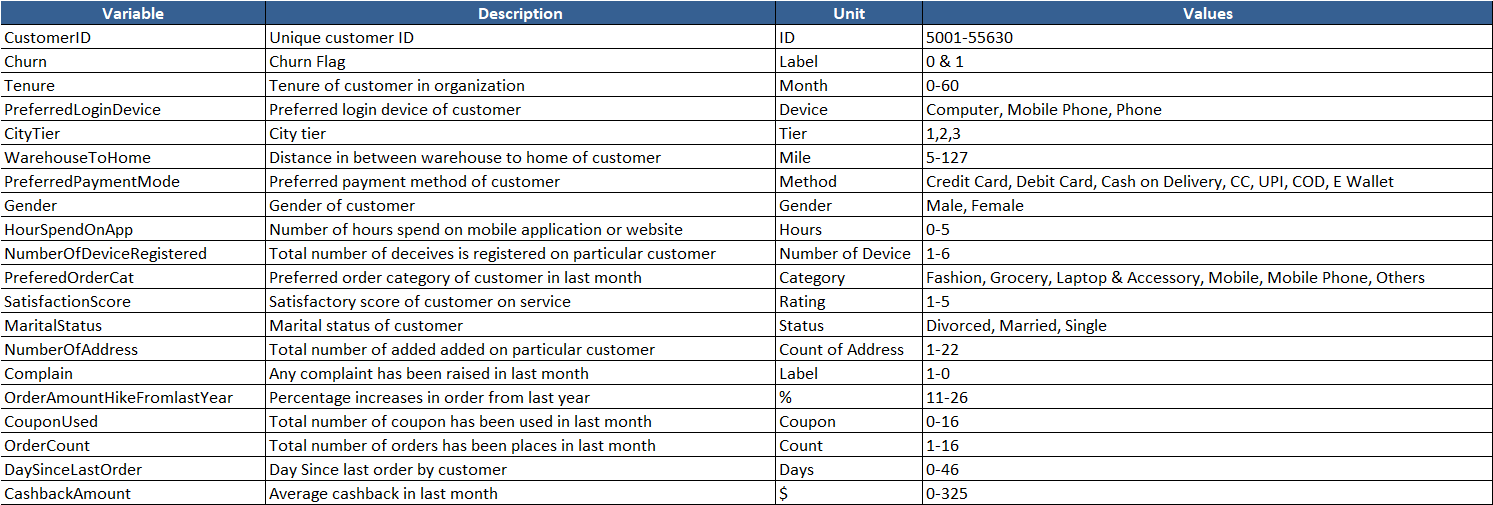

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures
from category_encoders import BinaryEncoder, OrdinalEncoder

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Metric
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, make_scorer, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

from scipy.stats import kruskal, mannwhitneyu

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier # bagging
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier # boosting
from xgboost import XGBClassifier #xgboost

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('D:\E Commerce Dataset.xlsx',sheet_name='E Comm')
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [3]:
df['Churn'].value_counts() / len(df)

0    0.831616
1    0.168384
Name: Churn, dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [5]:
pd.set_option('display.max_colwidth', -1)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,CustomerID,5630,"[50001, 50002, 50003, 50004, 50005, 50006, 50007, 50008, 50009, 50010, 50011, 50012, 50013, 50014, 50015, 50016, 50017, 50018, 50019, 50020, 50021, 50022, 50023, 50024, 50025, 50026, 50027, 50028, 50029, 50030, 50031, 50032, 50033, 50034, 50035, 50036, 50037, 50038, 50039, 50040, 50041, 50042, 50043, 50044, 50045, 50046, 50047, 50048, 50049, 50050, 50051, 50052, 50053, 50054, 50055, 50056, 50057, 50058, 50059, 50060, 50061, 50062, 50063, 50064, 50065, 50066, 50067, 50068, 50069, 50070, 50071, 50072, 50073, 50074, 50075, 50076, 50077, 50078, 50079, 50080, 50081, 50082, 50083, 50084, 50085, 50086, 50087, 50088, 50089, 50090, 50091, 50092, 50093, 50094, 50095, 50096, 50097, 50098, 50099, 50100, ...]"
1,Churn,2,"[1, 0]"
2,Tenure,36,"[4.0, nan, 0.0, 13.0, 11.0, 9.0, 19.0, 20.0, 14.0, 8.0, 18.0, 5.0, 2.0, 30.0, 1.0, 23.0, 3.0, 29.0, 6.0, 26.0, 28.0, 7.0, 24.0, 25.0, 10.0, 15.0, 22.0, 27.0, 16.0, 12.0, 21.0, 17.0, 50.0, 60.0, 31.0, 51.0, 61.0]"
3,PreferredLoginDevice,3,"[Mobile Phone, Phone, Computer]"
4,CityTier,3,"[3, 1, 2]"
5,WarehouseToHome,34,"[6.0, 8.0, 30.0, 15.0, 12.0, 22.0, 11.0, 9.0, 31.0, 18.0, 13.0, 20.0, 29.0, 28.0, 26.0, 14.0, nan, 10.0, 27.0, 17.0, 23.0, 33.0, 19.0, 35.0, 24.0, 16.0, 25.0, 32.0, 34.0, 5.0, 21.0, 126.0, 7.0, 36.0, 127.0]"
6,PreferredPaymentMode,7,"[Debit Card, UPI, CC, Cash on Delivery, E wallet, COD, Credit Card]"
7,Gender,2,"[Female, Male]"
8,HourSpendOnApp,6,"[3.0, 2.0, nan, 1.0, 0.0, 4.0, 5.0]"
9,NumberOfDeviceRegistered,6,"[3, 4, 5, 2, 1, 6]"


### Pre-EDA

### 1. Drop unnecessary column

- Customer ID = not relevant to analysis. each row already represent each customers
- Gender = avoid gender bias (MUNGKIN GA PERLU DIDROP)
- marital status = avoid marital status bias (MUNGKIN GA PERLU DIDROP)

In [6]:
df = df.drop(columns=['CustomerID'])  

# ,'Gender','MaritalStatus'])

### 2. Drop duplicates



In [7]:
df.duplicated().sum()

556

In [8]:
df = df.drop_duplicates()

### 3. Standardized categorical data

Some data has different spelling like CC and Credit Card means the same thing. Hence standardization for categorical data is important

- preferred login device --> mobile phone = phone
- preferred payment method --> CC = Credit Card, COD = Cash on Delivery
- PreferedOrderCat --> mobile = Phone

In [9]:
df['PreferredLoginDevice'] = df['PreferredLoginDevice'].replace('Mobile Phone','Phone')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace('CC','Credit Card')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace('COD','Cash on Delivery')
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace('Mobile','Mobile Phone')

## Exploratory Data Analysis

In EDA, we are going to proceed without imputing missing value. Because we would like to capture data that fully reflects the existing condition

### Categorical VS Numerical Analysis

In [26]:
df_churn = df.groupby('Churn').mean().reset_index(drop=False)
df_churn

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,0,11.495577,1.618238,15.273818,2.924994,3.632648,2.965745,4.134656,0.232695,15.752190,1.808342,3.123565,4.828914,180.790976
1,1,3.465718,1.860880,16.990909,2.950695,3.956005,3.341260,4.495838,0.533888,15.529625,1.794258,2.947879,3.328680,161.776897


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


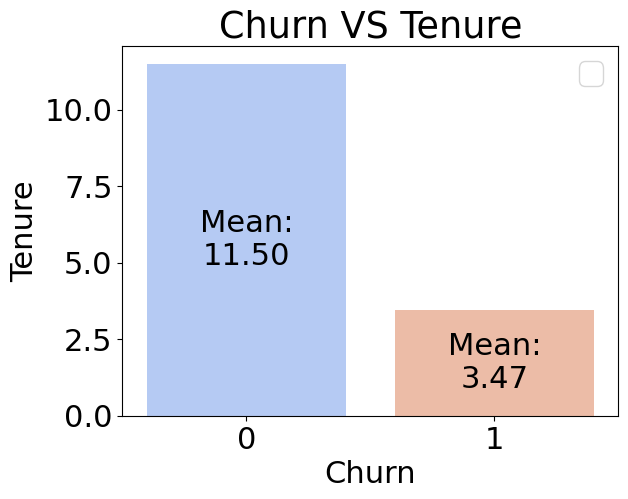

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


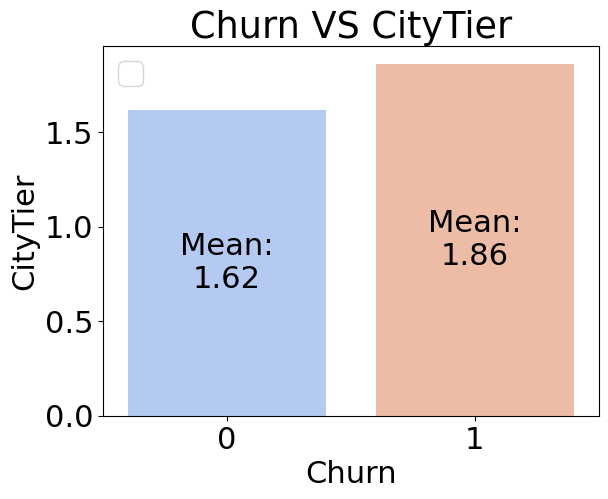

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


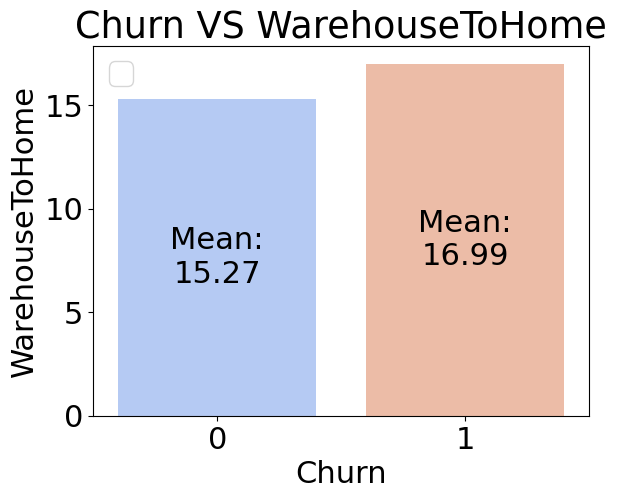

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


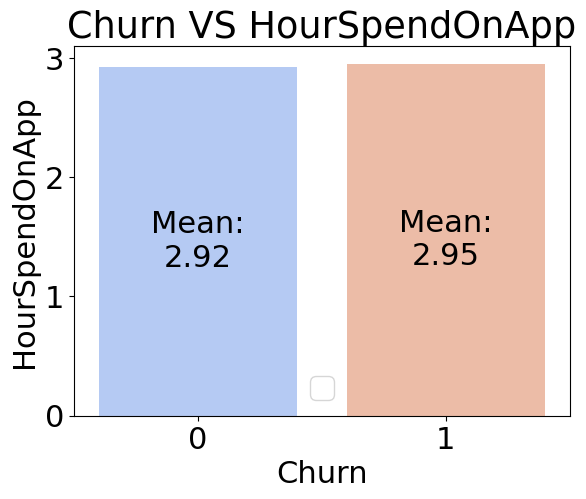

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


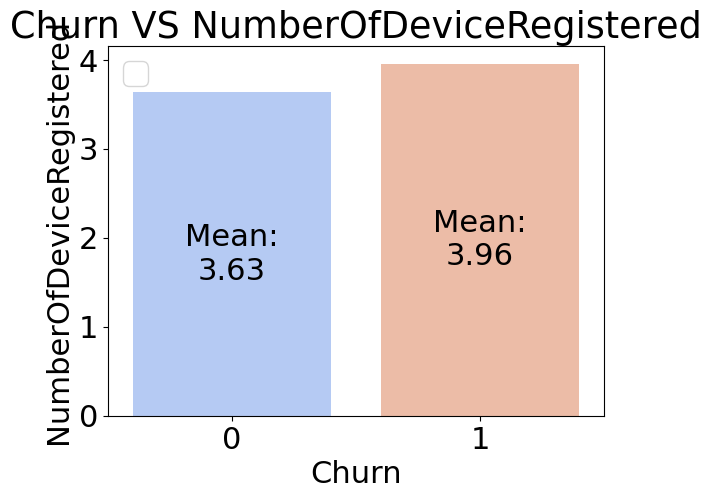

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


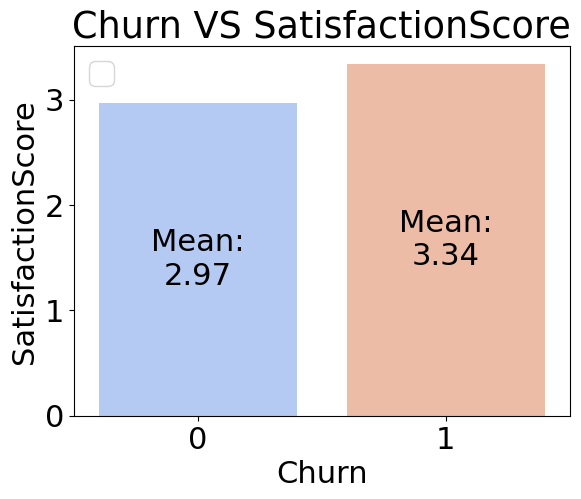

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


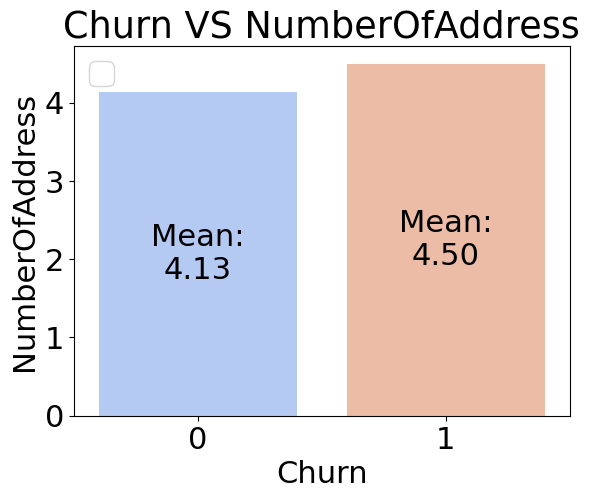

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


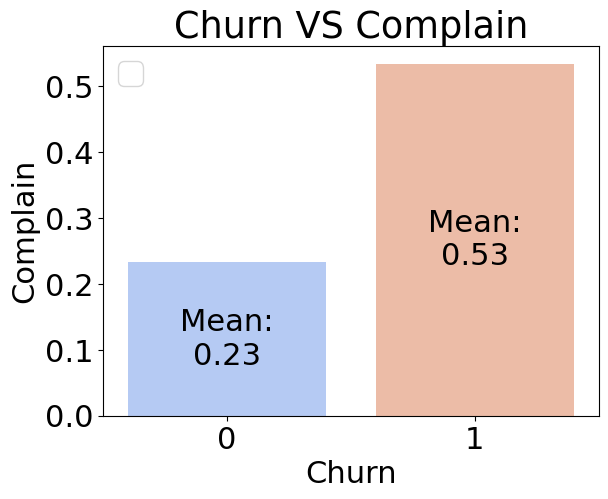

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


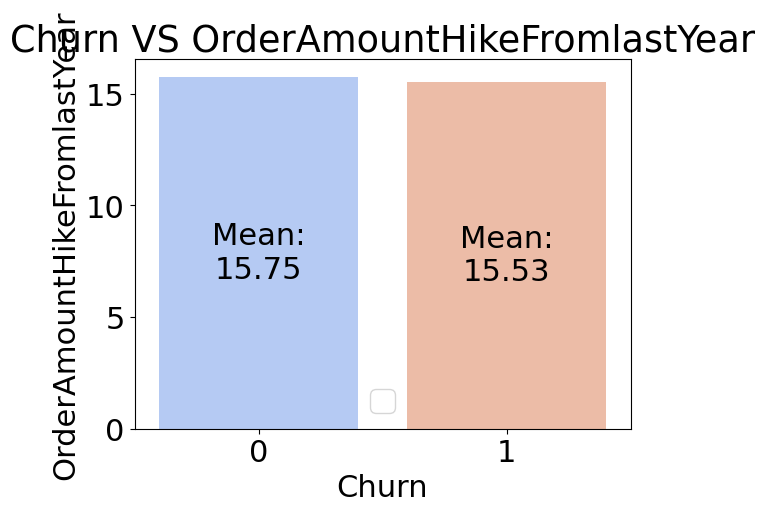

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


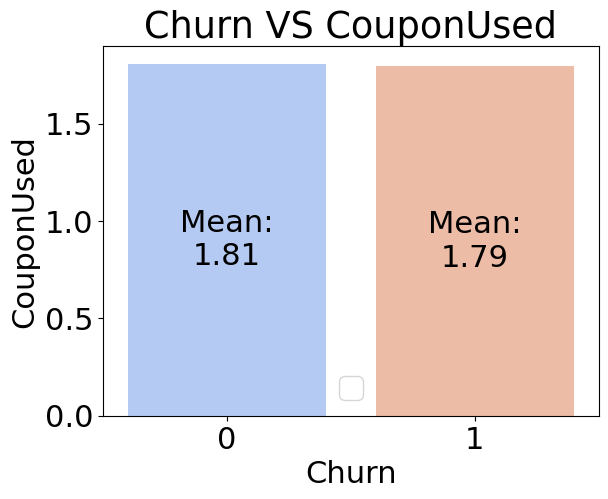

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


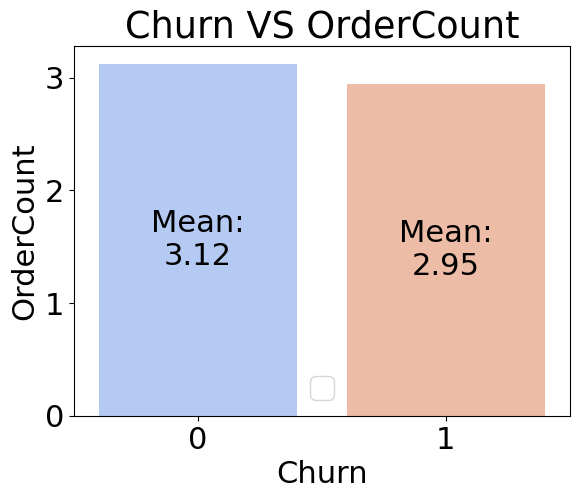

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


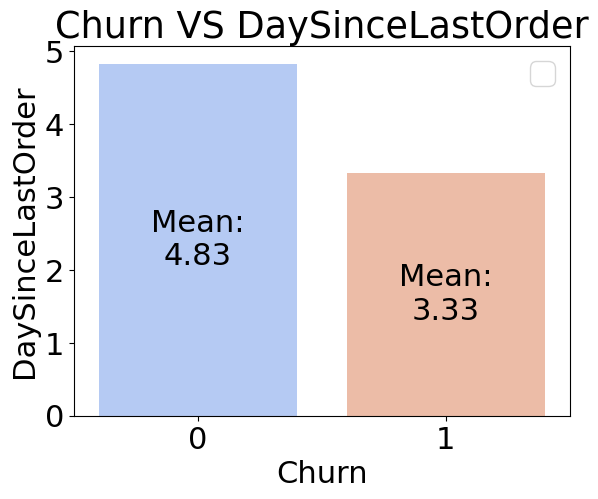

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


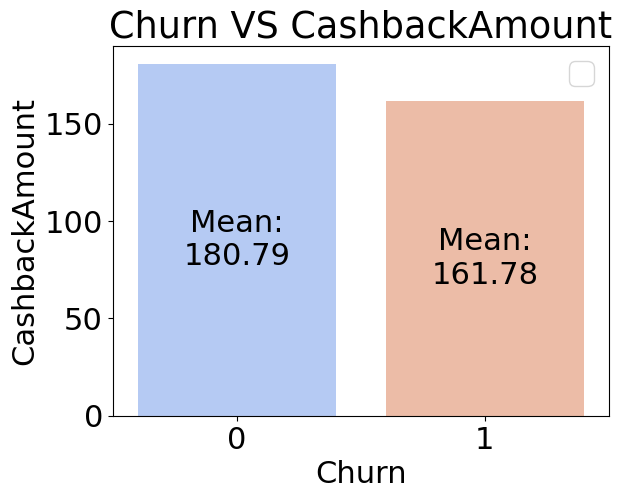

In [29]:
# plt.figure(figsize=(15,15))
plt.title('Churn Customers VS Factors')
a = 1

for i in df_churn.columns[1:]:
        ax= sns.barplot(data=df_churn,x='Churn',y=i,palette='coolwarm')
        for container in ax.containers:
            ax.bar_label(ax.containers[-1], fmt='Mean:\n%.2f', label_type='center')
        # plt.rcParams.update({'font.size': 22})
        # plt.tight_layout()
        plt.title(f'Churn VS {i}')
        plt.legend()

        a+=1
        # plt.suptitle('Loyal VS Churn Customers',fontsize=28)
        plt.show()

**Highlights:**

- Hypothesis testing is required to find out if there is any significant difference between two groups
- Churning customers has relative big difference in tenure. it means newer customers tend to churn while loyal customers has been around quite longer
- Satisfaction score for not churning is lower. this is quite interesting. Further analysis is required
- Churning customers is likely to complaint more
- Churning customers has ordered recently in average. Maybe there is a difference in their customer journey recently

#### Hypothesis Testing



##### Normality Assumption Check

Because it would determine what type of test we can run

Text(0.5, 0.98, 'Variable Distribution')

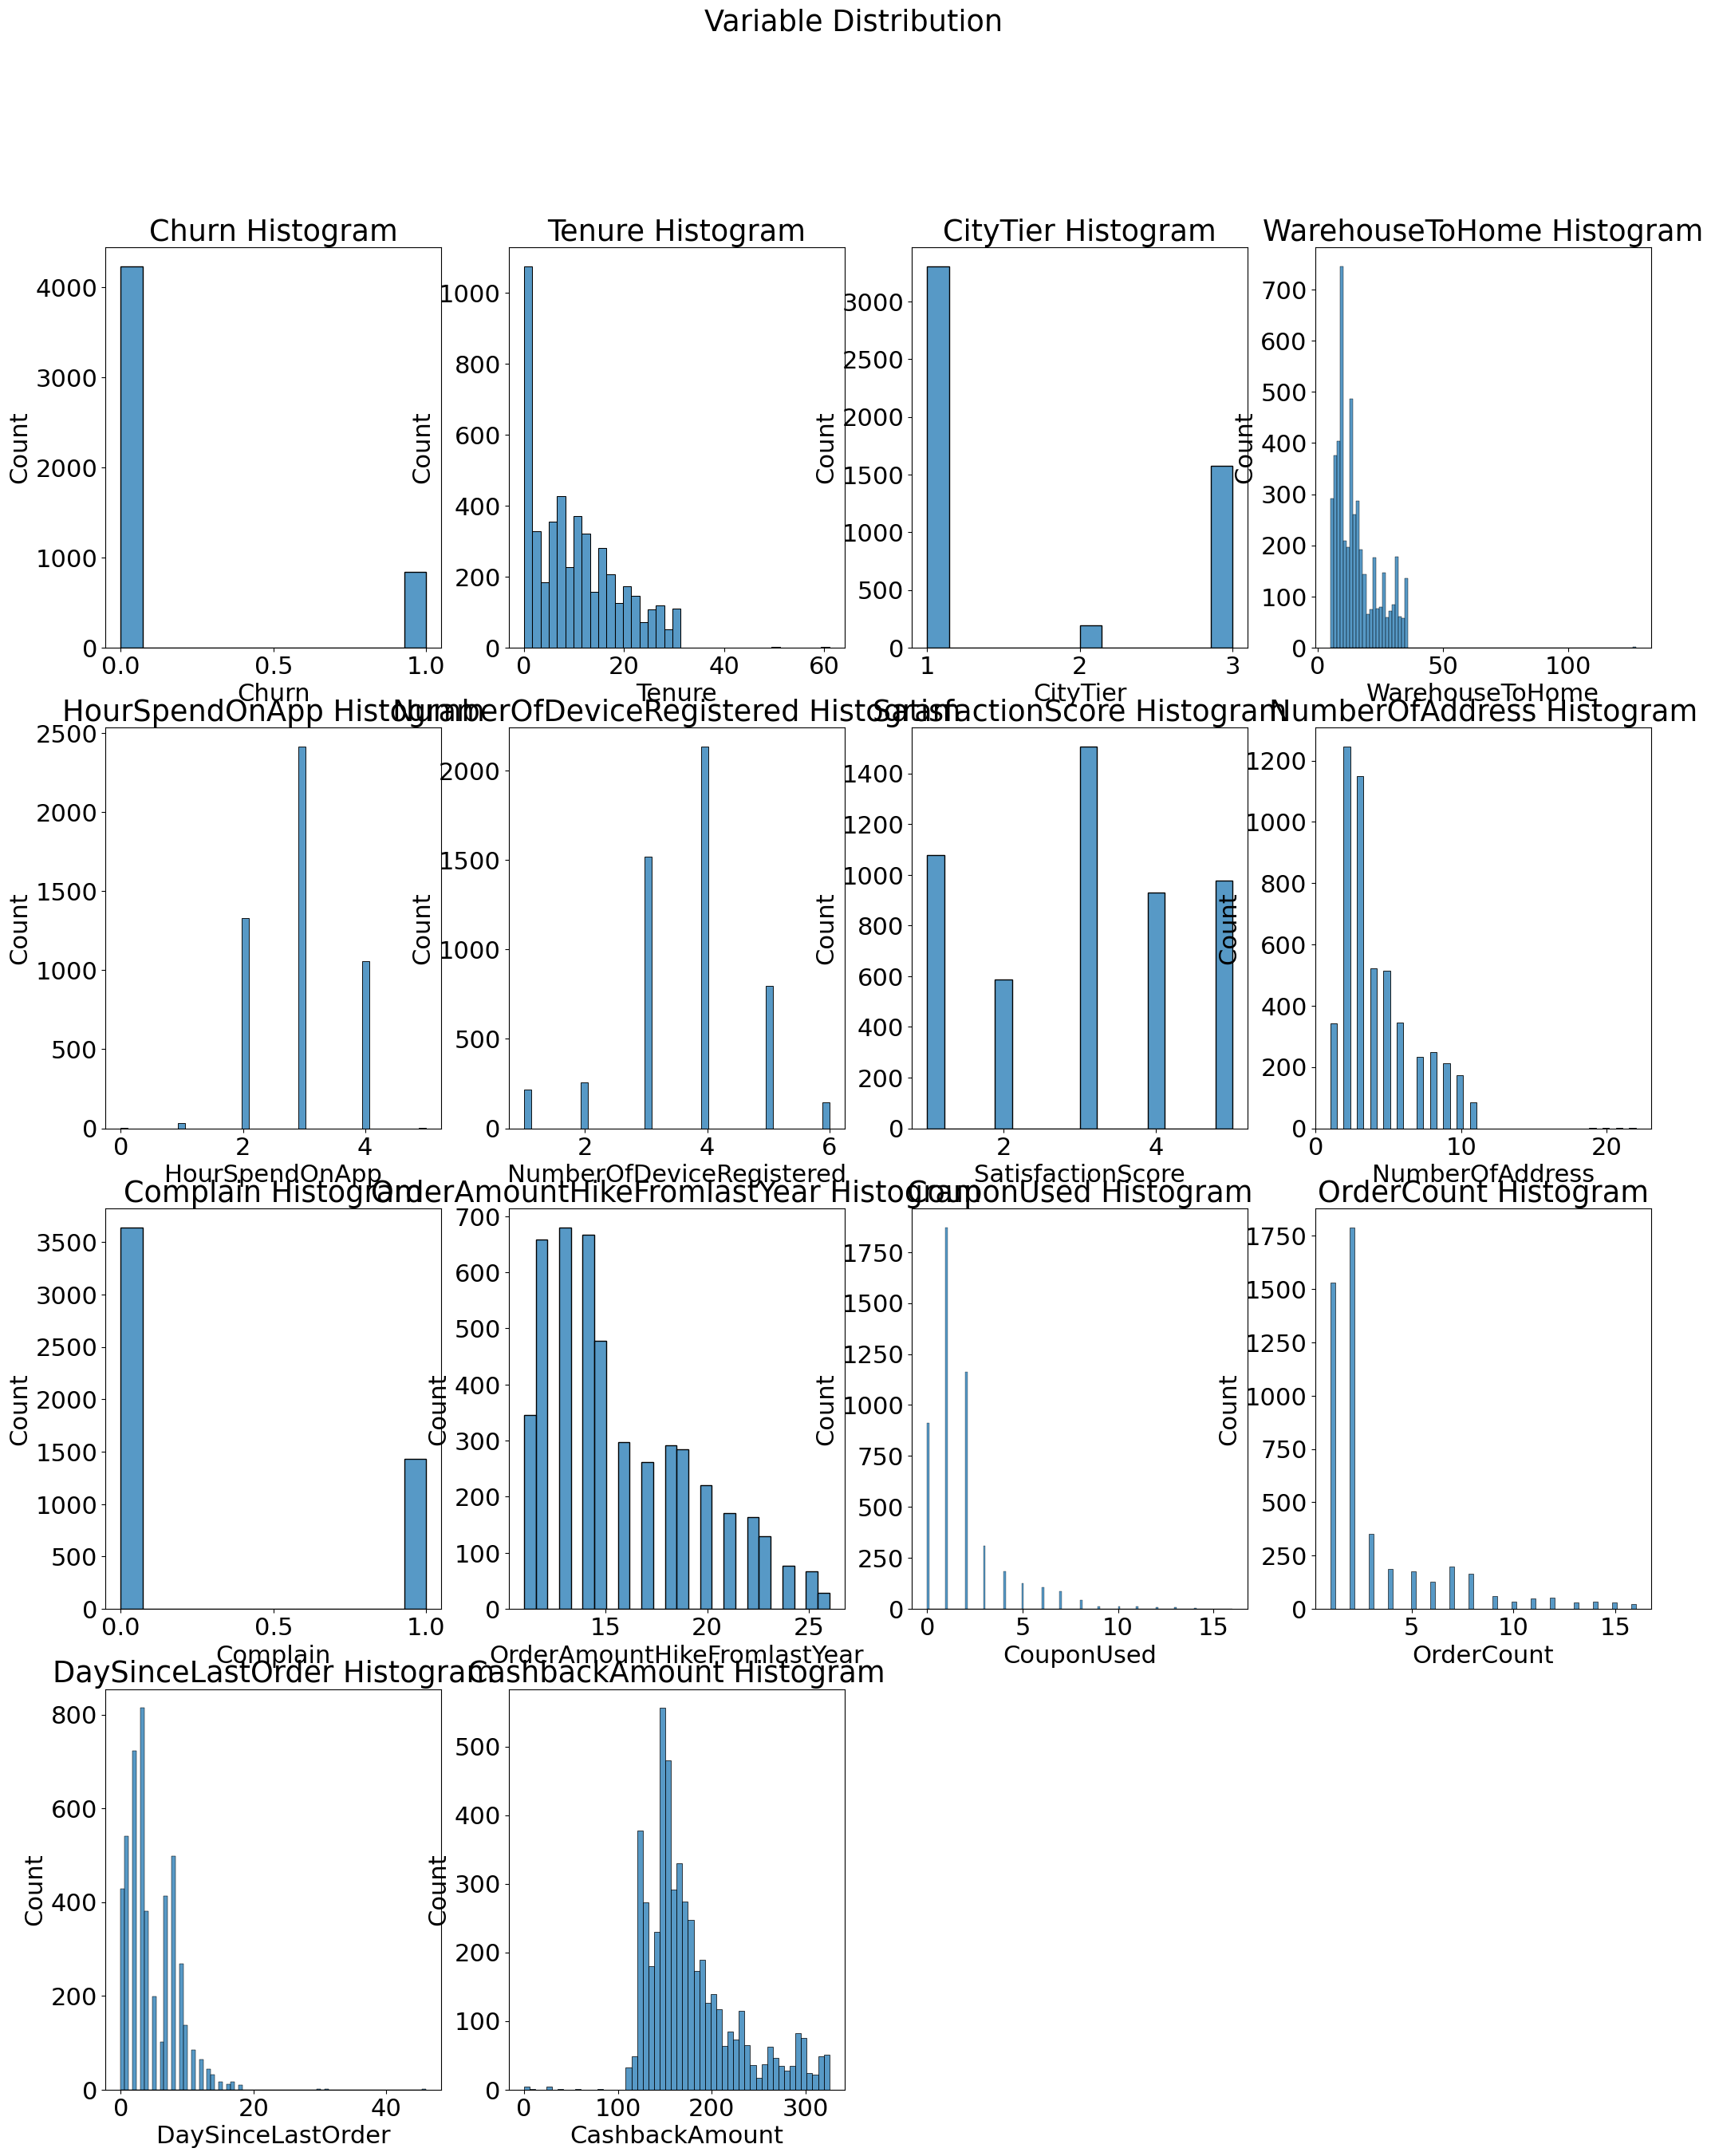

In [12]:
a=1
plt.figure(figsize=(25,30))

for col in df_churn:
    plt.subplot(4,4,a)
    plt.title(f'{col} Histogram')
    sns.histplot(data=df,x=col)
    a+=1
plt.suptitle('Variable Distribution')

**Interpretation:**

From the distribution, we can conclude none of the variable is normally distributed.

Hence, we are going to proceed with non-parametric test. For two unpaired test, we are going to use mann-whitney test

### Mann-Whitney Test

to find out if there is any significant difference between churning and not churning group. If there is, we can conclude the churning customers received different treatment

- **H0 = mean loyal customers  = mean churn customers**
- **H1 = mean loyal customers != mean churn customers**

**If Pvalue < 0.05, we would reject H0 and accept H1**

In [13]:
import scipy.stats as stats


In [14]:
df_not_churning = df[df['Churn'] == 0]

df_churning = df[df['Churn'] == 1]

for col in df_churn.columns[1:]:

    stat, pvalue = stats.mannwhitneyu(df_not_churning[col].dropna(),df_churning[col].dropna(),alternative= 'two-sided')
    if pvalue < 0.05:
        print(f''' pvalue for {col} is {pvalue}, which is less than 0.05. Therefore, we have enough evidence to reject H0
        ''')
    else:
        print(f''' pvalue for {col} is {pvalue}, which is more than 0.05. Therefore, we do not have enough evidence to reject H0
        ''')

 pvalue for Tenure is 3.5033214744029166e-168, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for CityTier is 3.349728711590277e-12, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for WarehouseToHome is 5.69665551567953e-08, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for HourSpendOnApp is 0.45352090838488657, which is more than 0.05. Therefore, we do not have enough evidence to reject H0
        
 pvalue for NumberOfDeviceRegistered is 4.690627647169329e-15, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for SatisfactionScore is 9.9125867273846e-13, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for NumberOfAddress is 0.004992881871819556, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for Complain is 3.138081183693644e-70, whic

**Interpretation:**

- Tenure: Exist significant difference. Older customers tend to be loyal

- City tier: exist significant difference. Customer from city tier 2 and 3 tend to churn. (FITUR DULU BARU TARGET)
- Warehouse to home: exist significant difference. Customers who live further from warehouse tend to churn, may be caused by longer delivery time
- hour spend on app: significant difference is not exist. both group spend similar time on app, may mean good UI/UX
- Number of device registered: exist significant difference. Churning customers has higher number of device registered.
- Satisfaction Score: exist significant difference. Customers who rates high satisfaction tend to churn. Further investigation is required.
- Number of address: significant difference is not exist. both group register similar number of address
- complaint: exist significant difference. Customers who complaint is more likely to churn
- order amount hike from last year: significant difference is not exist. Churning customers has similar amount of increase with loyal customers
- Coupon used: significant difference is not exist. Churning customers also use similar amount of coupon as loyal customers
- Order count: significant difference is not exist. Churning customers placed similar amount of orders as loyal customers
- Day since last order: exist significant difference. customers who bought things recently is more likely to churn, maybe a new thing has been implemented recently
- Cashback amount: exist significant difference. Customers with lower cashback is more likely to churn

### Categorical VS Categorical Analysis

Churning customers vs (Gender, Marital Status, Preferred Login Device, Preferred Payment Mode, Preferred Order Category)

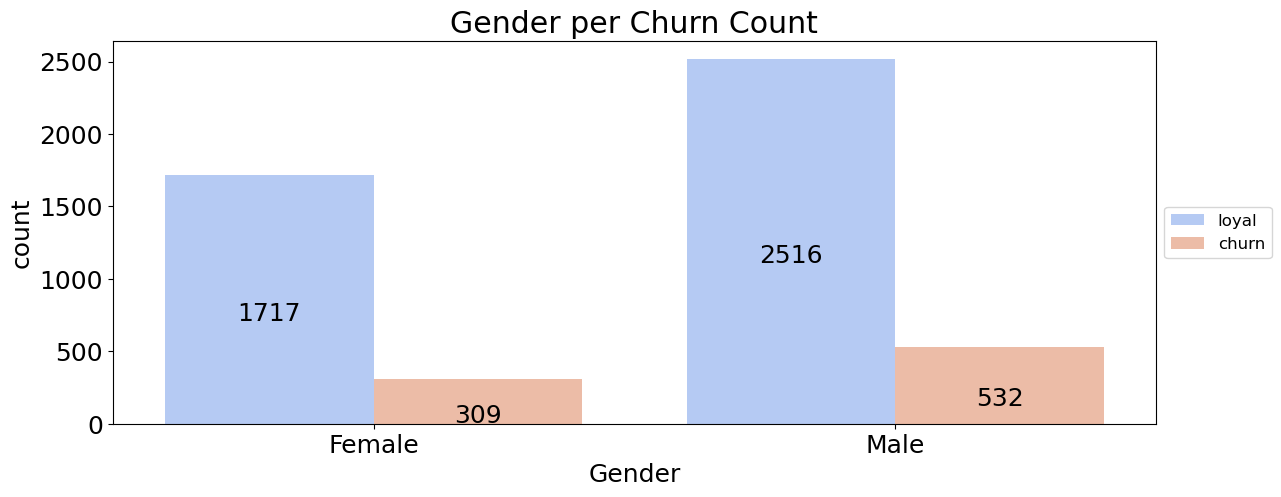

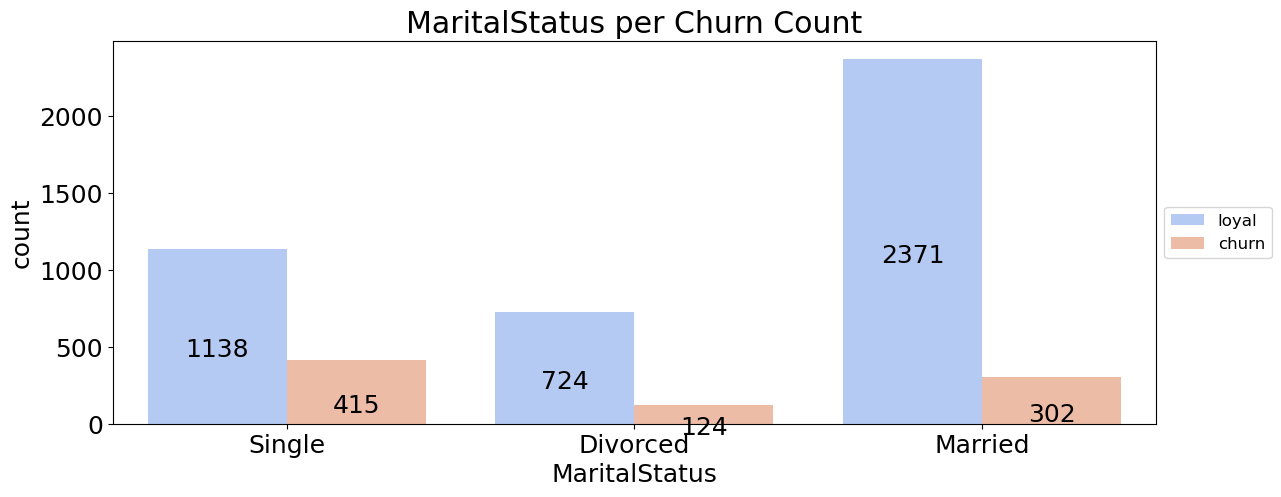

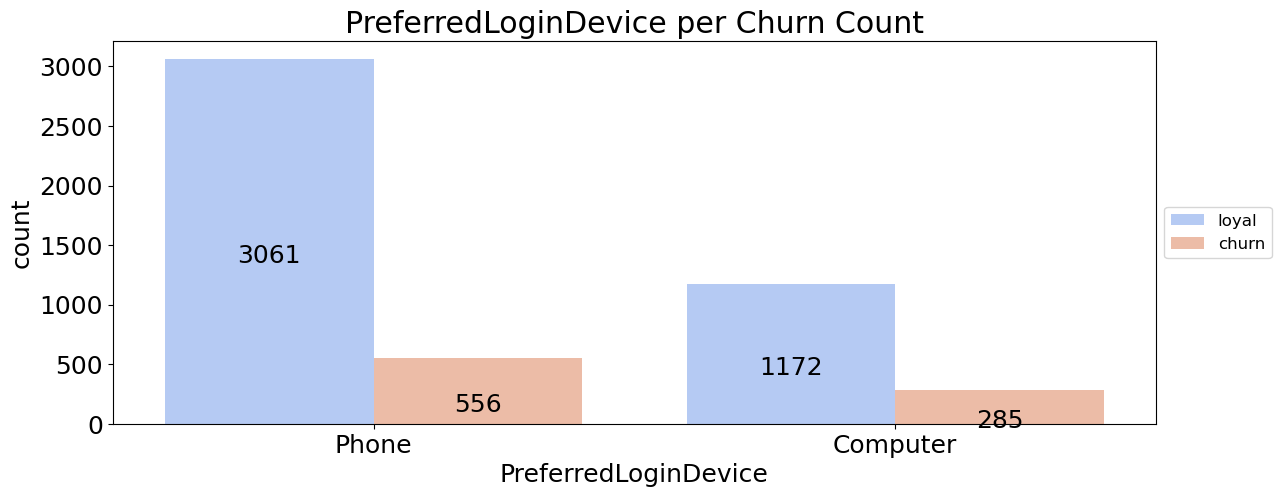

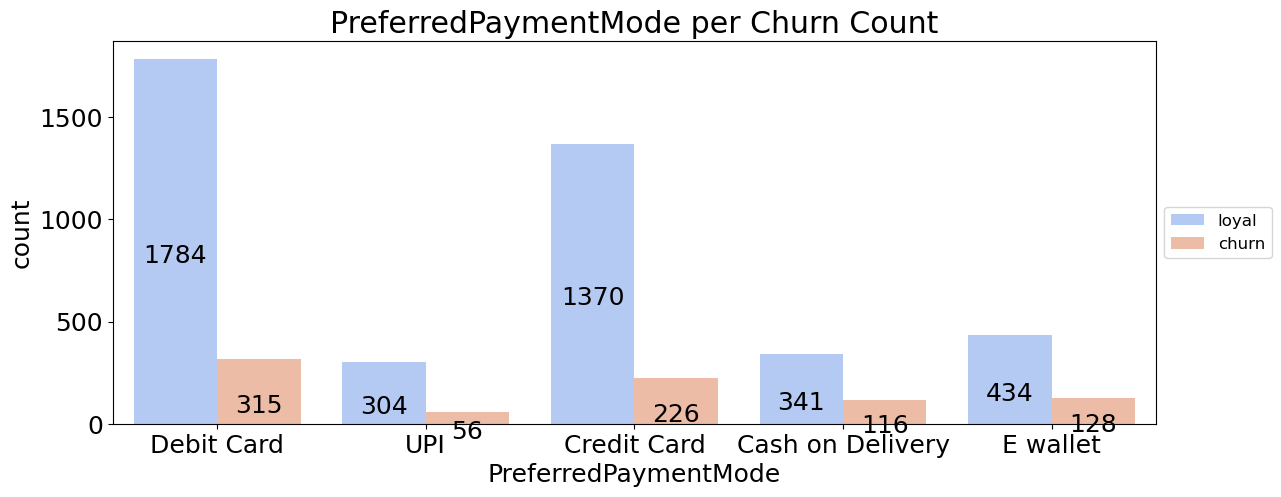

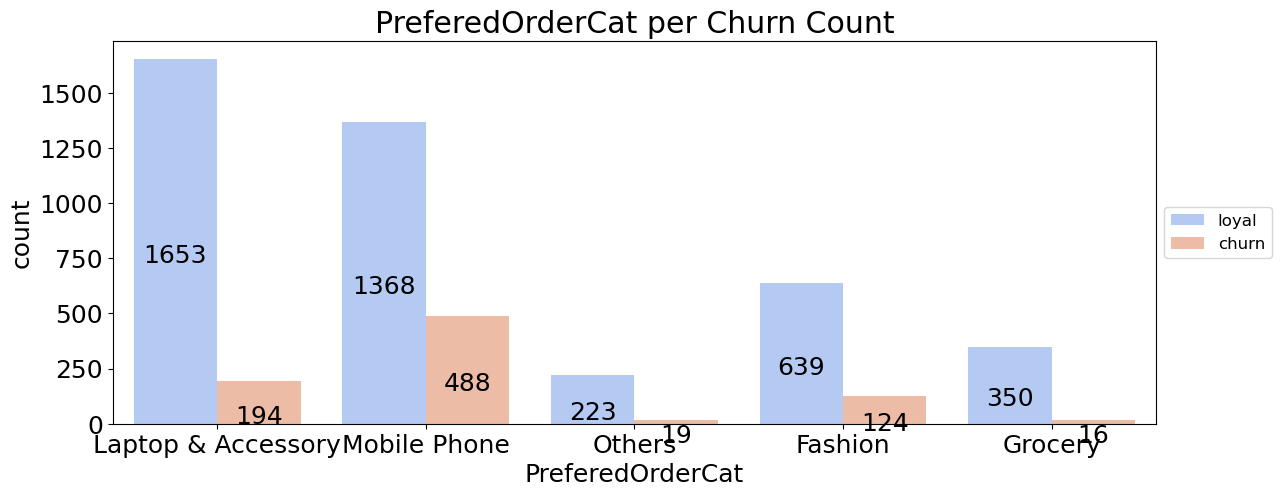

In [45]:

a = 1
for col in ['Gender','MaritalStatus','PreferredLoginDevice','PreferredPaymentMode','PreferedOrderCat']:
    plt.figure(figsize = (12,5))
    # plt.subplot(3,2,a)

    ax = sns.countplot(x =col, data = df, hue ='Churn', palette ="coolwarm" )
    for container in ax.containers:
        ax.bar_label(container, fmt='\n%.f', label_type='center')

    # plt.rcParams.update({'font.size': 18})
    plt.tight_layout()
    # format graph
    plt.title(f"{col} per Churn Count")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12,labels=['loyal','churn'])
    plt.show()
    a += 1


In [16]:
for col in ['Gender','MaritalStatus','PreferredLoginDevice','PreferredPaymentMode','PreferedOrderCat']:
    df_a = pd.crosstab(df['Churn'],df[col],normalize='columns')
    df_a = df_a*100
    display(pd.DataFrame(df_a))

Gender,Female,Male
Churn,,
0,84.748272,82.545932
1,15.251728,17.454068


MaritalStatus,Divorced,Married,Single
Churn,,,
0,85.377358,88.701833,73.277527
1,14.622642,11.298167,26.722473


PreferredLoginDevice,Computer,Phone
Churn,,
0,80.439259,84.628145
1,19.560741,15.371855


PreferredPaymentMode,Cash on Delivery,Credit Card,Debit Card,E wallet,UPI
Churn,,,,,
0,74.617068,85.839599,84.992854,77.224199,84.444444
1,25.382932,14.160401,15.007146,22.775801,15.555556


PreferedOrderCat,Fashion,Grocery,Laptop & Accessory,Mobile Phone,Others
Churn,,,,,
0,83.748362,95.628415,89.496481,73.706897,92.14876
1,16.251638,4.371585,10.503519,26.293103,7.85124


**Highlights:**

- 17% male customers stopped buying vs 15% of female
- Single customers are more likely to churn rather than divorced or married customers 
- 19% customers who prefer to log in through computer has churned
- 25% and 22% customers who prefer to use COD and E-wallet has churned respectively
- Quarter of customers who preferred to buy mobile phone has churned

#### Chi-square Test

Test independency between churning and not churning group with categorical variables ('Gender','MaritalStatus','PreferredLoginDevice','PreferredPaymentMode','PreferedOrderCat')

- **H0 = Churning customers is independent to variable**
- **H1 = Churning customers is dependent to variable**

**If Pvalue < 0.05, we would reject H0 and accept H1**

In [17]:
from scipy.stats import chi2_contingency

In [18]:
for col in ['Gender','MaritalStatus','PreferredLoginDevice','PreferredPaymentMode','PreferedOrderCat']:
    df_col = pd.crosstab(df['Churn'],df[col])
    stat, pvalue, dof, expexted = chi2_contingency(df_col)
    if pvalue < 0.05:
        print(f''' pvalue for {col} is {pvalue}, which is less than 0.05. Therefore, we have enough evidence to reject H0
        ''')
    else:
        print(f''' pvalue for {col} is {pvalue}, which is more than 0.05. Therefore, we do not have enough evidence to reject H0
        ''')
    


 pvalue for Gender is 0.04259894419755922, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for MaritalStatus is 4.908789651387262e-38, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for PreferredLoginDevice is 0.0003323467402304037, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for PreferredPaymentMode is 1.380036138713521e-10, which is less than 0.05. Therefore, we have enough evidence to reject H0
        
 pvalue for PreferedOrderCat is 2.3935822310203708e-48, which is less than 0.05. Therefore, we have enough evidence to reject H0
        


**Interpretation:**

- Gender is related whether someone will churn or not. Female tend to like our service/UI/UX more.
- Marital Status is related whether someone will churn or not. Single customers tend to churn more than married or divorced customers.
- Login device is related whether someone will churn or not. May be customer journey/UI/UX in computer is not as good on mobile.
- Payment mode is related whether someone will churn or not. Some payment method may often get failed or with extra charge.
- Order category is related whether someone will churn or not. Company may give less-than-satisfactory service on specific category

### Numerical VS Numerical Analysis

#### Correlation Analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


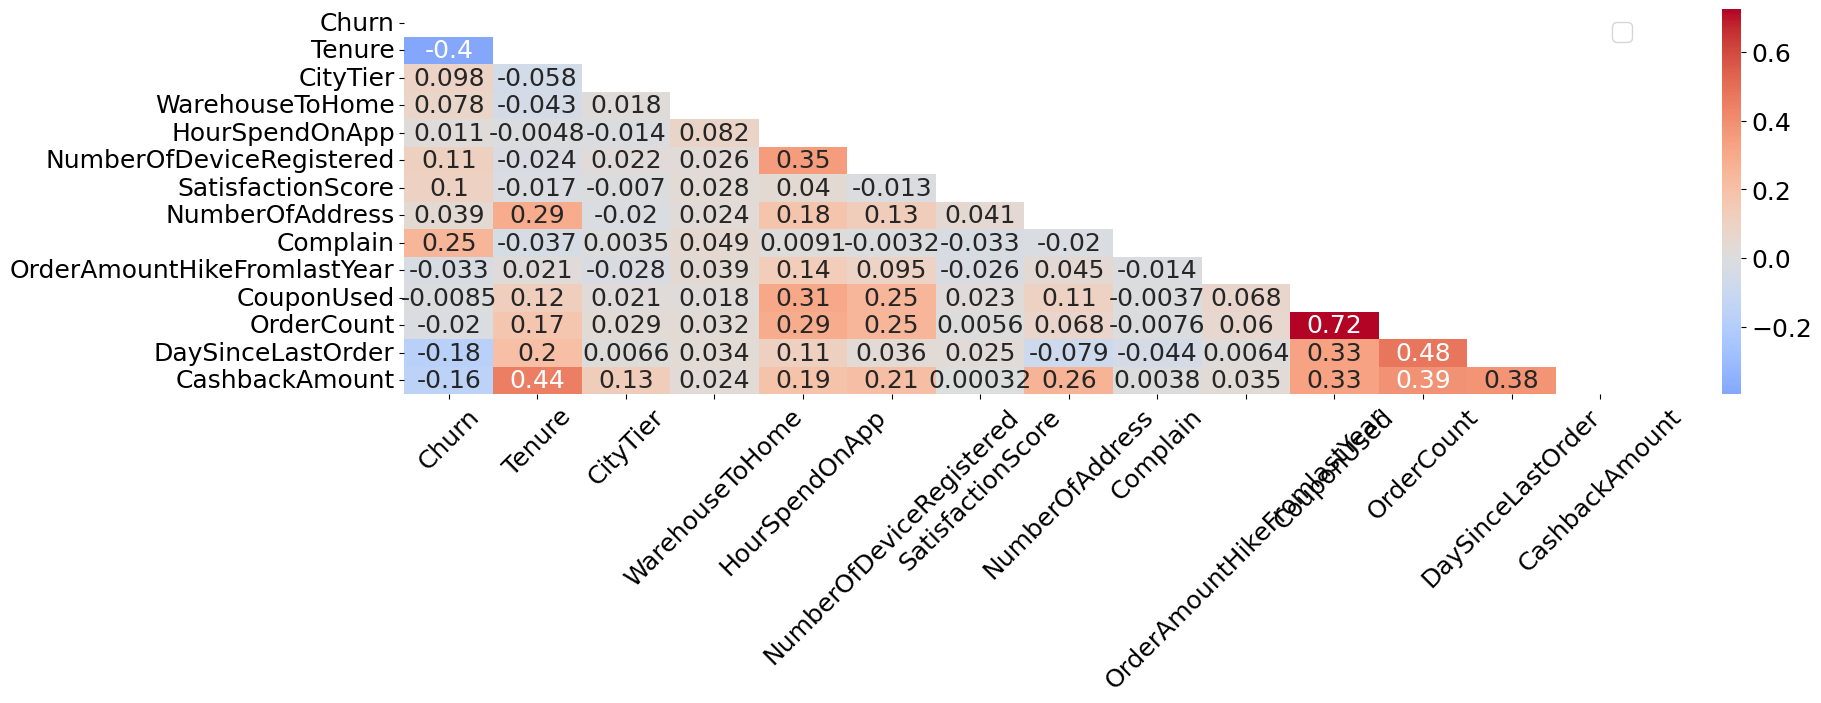

In [19]:
matrix = np.triu(df.corr(method='spearman'))
plt.figure(figsize = (20,5))

sns.heatmap(data=df.corr(method='spearman'),annot=True,cmap='coolwarm',center=0,mask= matrix)
plt.xticks(rotation=45)
plt.legend()

**Highlights:**

- Tenure has medium correlation with churning customers.
- Complaint has weak correlation with churning customers
- The rest of variables has very weak correlation with churning customers
- Coupon used has strong correlation with order count

## Churn Customers Group

In [20]:
df_churn = df[df['Churn']==1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

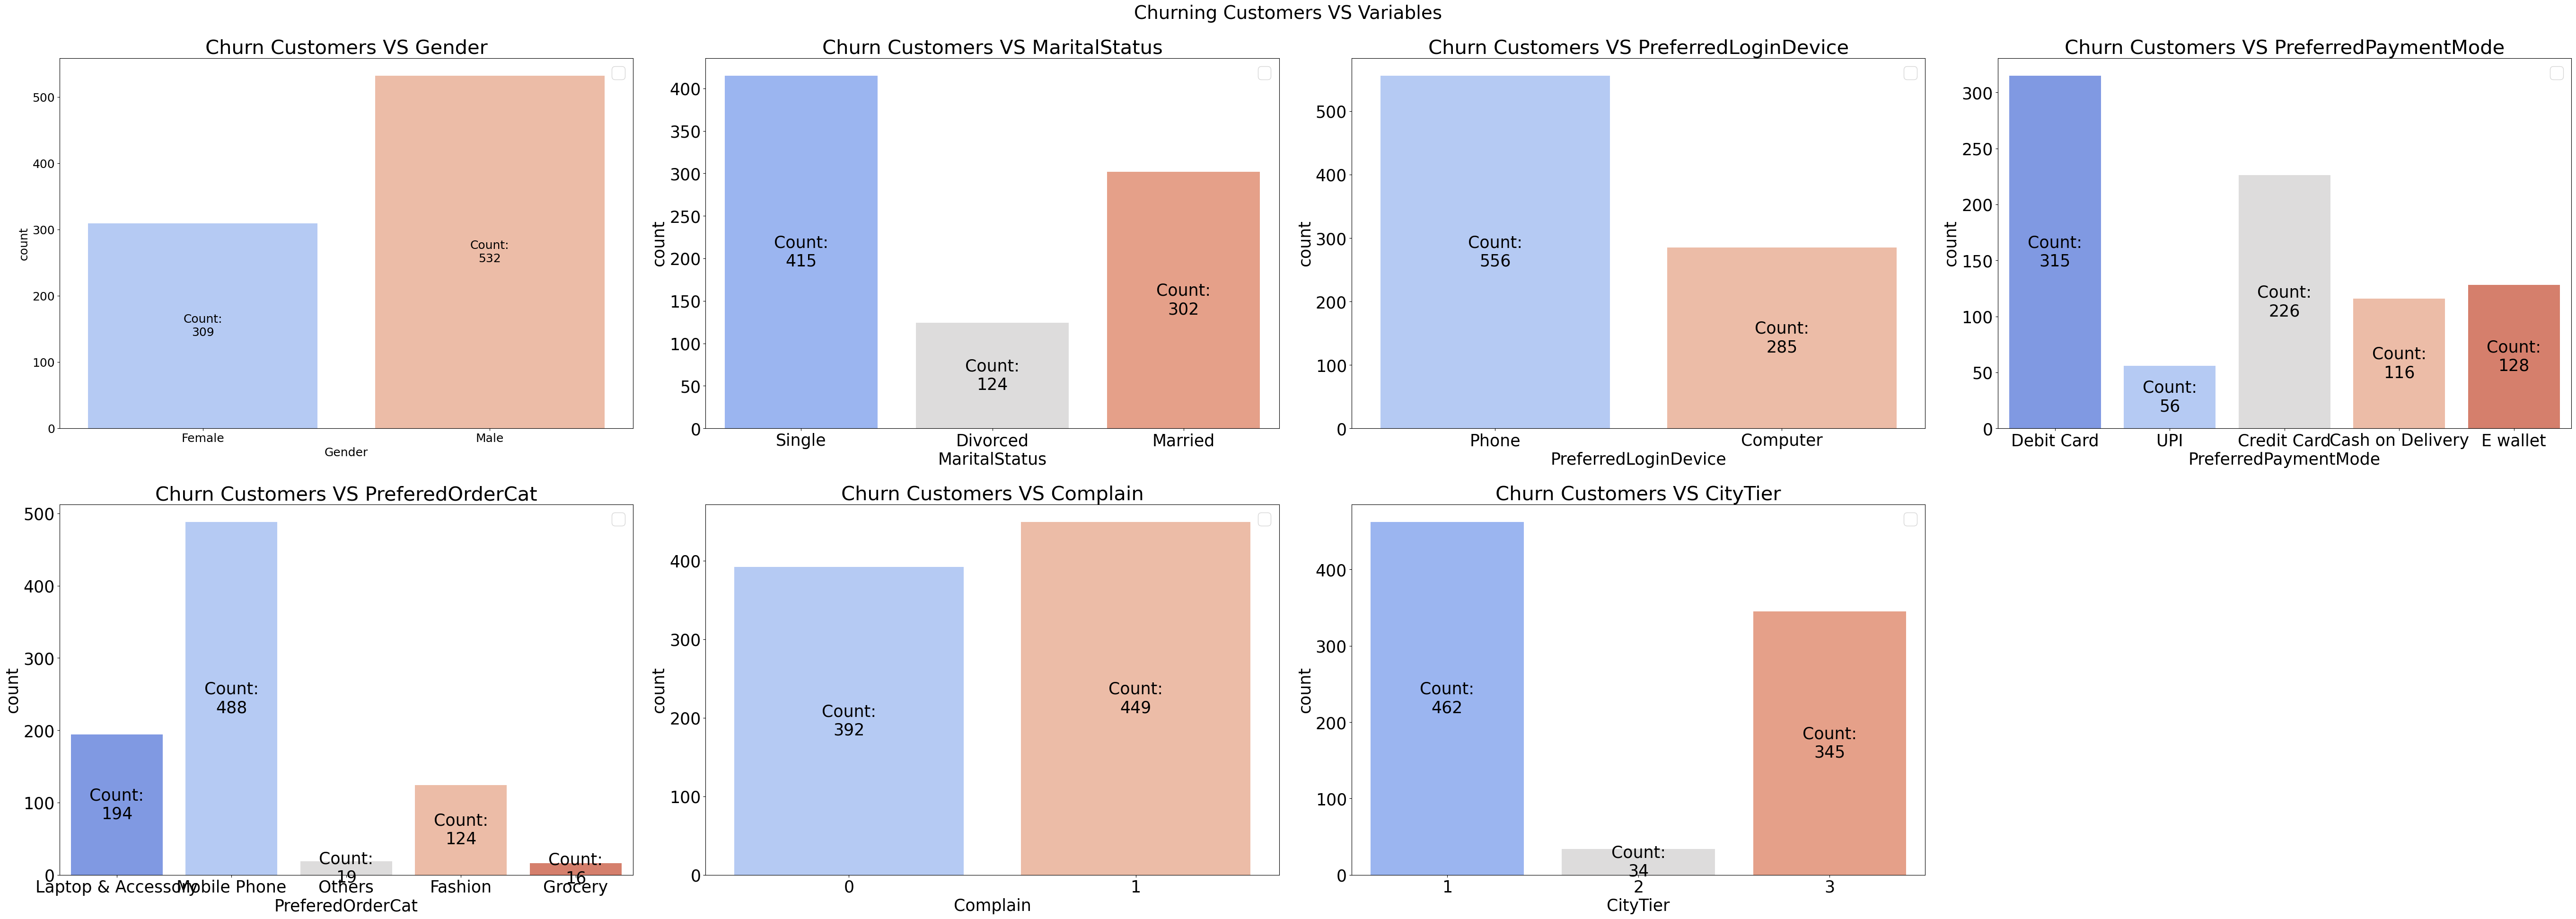

In [21]:
plt.figure(figsize=(55,20))
plt.title('Churn Customers')
a = 1

for col in ['Gender','MaritalStatus','PreferredLoginDevice','PreferredPaymentMode','PreferedOrderCat','Complain','CityTier']:
        plt.subplot(2,4,a)
        ax= sns.countplot(data=df_churn,x=col,palette='coolwarm')
        for container in ax.containers:
            ax.bar_label(ax.containers[-1], fmt='Count:\n%2.f', label_type='center')
        plt.rcParams.update({'font.size': 25})

        plt.tight_layout()
        plt.title(f'Churn Customers VS {col}')
        plt.legend()

        a+=1
        plt.suptitle('Churning Customers VS Variables',fontsize=28)

**Highlights:**

- 65% churn customers use Debit and Credit Card
- Only 4% churn customers from City Tier 2
- 81% churn customers bought technology device (mobile phone + Laptop)
- High percentage of phone user

## Review and Highlights

- Older customers tend to be loyal. As they are likely to develop sense of loyalty
- Churn customer has higher satisfaction score. May mean we loyal customer stays because of emotional or not trying other option
- Interestingly, churn customer also tend to file complaint. 
- Churn and loyal customers use similar number of coupons, order and order amount increase from last year. May mean pricing and sales part are good
- But loyal customers received higher cashbacks
- Coupon is distributed equally as loyal and churn customers receieve similar amount

- There may be differences in how male and female perceive company's products or services which affect chrun. 
- Married individuals has different concern than unmarried customers. 
- Customers certain device may encounter technical issues  which coul affect likelihood of churning
- Customers may have different expectations or preferences when it comes to the company's billing or checkout processes, which could affect their loyalty
- Customers who prefer certain types of products may have different needs or preferences when it comes to the company's offerings

- 81% churning customers bought tech device (laptop or phone)


## Recommendation

- Develop clear and seamless onboarding process, to ensure new customers experience in both computer and phone.
- Analyze and implement customer's complaint as their input is very valuable
- Develop loyalty programs for each customer segment. Especially single customer, mobile phone category as they have higher churn rate
- Clear UI/UX on phone and computer
- Increase product and seller quality especially in mobile phone and laptop category

# Define X and y

In [22]:
df.head(1)

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,4.0,Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93


In [23]:
X = df.drop(columns='Churn')

y = df['Churn']

# Data Splitting

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)


## Pre-processing

Checking Missing Values

In [25]:
X.isna().sum()

Tenure                         231
PreferredLoginDevice           0  
CityTier                       0  
WarehouseToHome                221
PreferredPaymentMode           0  
Gender                         0  
HourSpendOnApp                 230
NumberOfDeviceRegistered       0  
PreferedOrderCat               0  
SatisfactionScore              0  
MaritalStatus                  0  
NumberOfAddress                0  
Complain                       0  
OrderAmountHikeFromlastYear    252
CouponUsed                     210
OrderCount                     243
DaySinceLastOrder              288
CashbackAmount                 0  
dtype: int64

Checking Duplicated Data

In [26]:
X.duplicated().sum()

1

dropping the duplicated data

In [27]:
X = X.drop_duplicates()

In [28]:
X.head(1)

,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,4.0,Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93


Code Below Is for Getting The Columms That are Categorical

In [29]:
category_columns = [feature for feature in X.columns if (X[feature].dtypes == 'O')]
category_columns

['PreferredLoginDevice',
 'PreferredPaymentMode',
 'Gender',
 'PreferedOrderCat',
 'MaritalStatus']

this code below is for getting the unique values of the categorical column, which we loop to get all the columns unique values at once

In [30]:
for i in category_columns:
    print(f'Total unique values in {i}: ', X[i].nunique())
    print(f'Unique values: ', X[i].unique())
    print()

Total unique values in PreferredLoginDevice:  2
Unique values:  ['Phone' 'Computer']

Total unique values in PreferredPaymentMode:  5
Unique values:  ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']

Total unique values in Gender:  2
Unique values:  ['Female' 'Male']

Total unique values in PreferedOrderCat:  5
Unique values:  ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']

Total unique values in MaritalStatus:  3
Unique values:  ['Single' 'Divorced' 'Married']



Code below is for checking the outliers of numerical columns with barplot, and im using looping to show it all at once

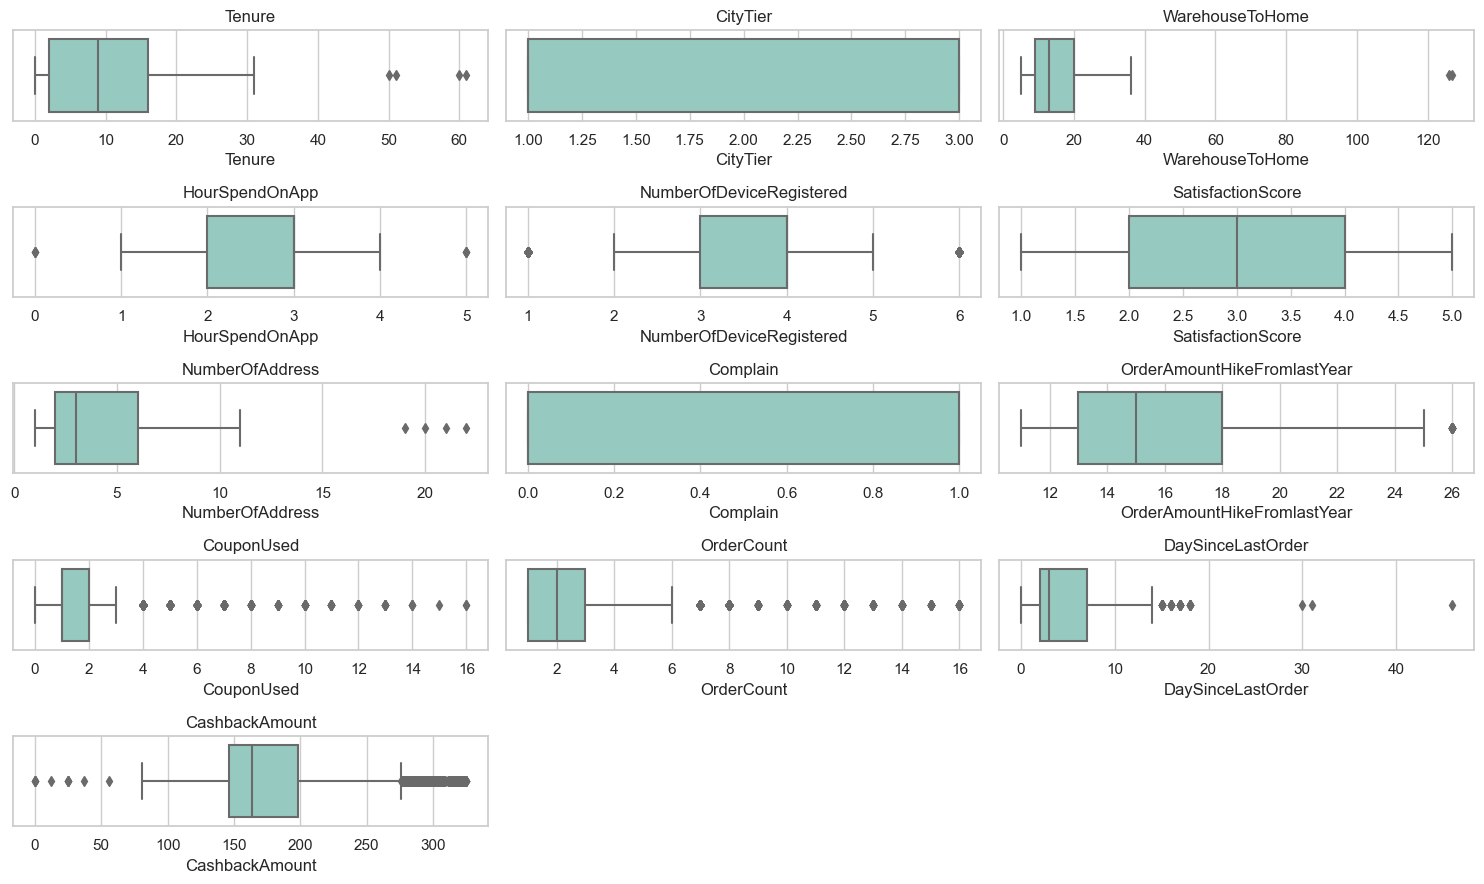

In [31]:
# Numerical Features
num_feature = [fea for fea in X.describe().columns]
num_feature

plt.figure(figsize=(15, 9), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(5,3, plotnumber)
    sns.boxplot(x=feature, data=X);
    plt.title(feature, fontsize=12)
    plt.tight_layout()
    plotnumber += 1

recatgorized coupon, num of address, tenure, order count, day since last order, hike order

Dropping number of address that are 20 >=

Dropping Warehousetohome above 120

the other i conclude its important to determine churn

Dropping Tenure

In [32]:
X = X[~(X['Tenure'] >= 50)]

Dropping NumberOfAddress Outlier

In [33]:
X = X[~(X['NumberOfAddress'] >= 19)]

Dropping WarehouseToHome

In [34]:
X = X[~(X['WarehouseToHome'] > 120)]

# Creating Pipeling and Column Transformer for Pre-Processing

fill Missing Value Using Median and scaling: Tenure,WarehouseToHome,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount, and DaySinceLastOrder

onehot encoder:PreferredLoginDevice,PreferredPaymentMode, Gender,PreferedOrderCat and MaritalStatus



In [35]:
X.describe().columns

Index(['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [36]:
category_columns

['PreferredLoginDevice',
 'PreferredPaymentMode',
 'Gender',
 'PreferedOrderCat',
 'MaritalStatus']

In [37]:
# Creating Pipeling for Collummns that we will fill the misssing value with median and then we scale, the numerical category that has no missing value we still input here because it will just pass it but it will go through the scaling too
pipe_median_poly_scaling = Pipeline([
    ('median', SimpleImputer(strategy='median')),
    ('poly',PolynomialFeatures(degree=1)),
    ('scaling',RobustScaler())
])


# Creating ColumnTransformer for the pipeline
transformer = ColumnTransformer([
    ('pipe_median_scaling',pipe_median_poly_scaling, ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount']),
    ('onehot', OneHotEncoder(drop='first'),['PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus'])
],remainder='passthrough')

# Cross Validation

This steps is to find the best benchmark algorithm

In [38]:
# 3 Base Learner (Basic ML algorithm)
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0, max_depth=5)


# 4 ensemble model
rf = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
xgboost  = XGBClassifier()

This code below is to see the best algorithm for our case, and to check that i will create a loop checking each and everyone of the algorithm

In [39]:
list_model = [logreg,knn,tree,rf,adaboost,gboost,xgboost]           #containing all the algorithm to use in the looping
list_all = []
list_mean = []
list_std = []

#Create a loop to check each algorithm in list_model to find the mean and std so we can choose the best algorithm to use
for model in list_model:

    pipe_model = Pipeline([
        ('transformer',transformer),
        ('sampling',RandomOverSampler(random_state=0)),
        ('model', model)
    ])

    model_cv = cross_val_score(
        estimator=pipe_model,
        X = X_train,
        y = y_train,
        cv = 5,
        scoring='recall',
        error_score='raise'

    )

    list_all.append(model_cv.round(4))
    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())

In [40]:
X_score = pd.DataFrame({
    'algo':list_model,
    'mean' : list_mean,
    'std' : list_std,
    'all' : list_all
})

In [39]:
X_score

,algo,mean,std,all
0,LogisticRegression(random_state=0),0.806954,0.038451,"[0.7481, 0.8074, 0.7852, 0.8582, 0.8358]"
1,KNeighborsClassifier(),0.882664,0.023399,"[0.9037, 0.8444, 0.8667, 0.8955, 0.903]"
2,"DecisionTreeClassifier(max_depth=5, random_state=0)",0.775810,0.057899,"[0.6889, 0.7852, 0.7333, 0.8433, 0.8284]"
3,RandomForestClassifier(random_state=0),0.803936,0.025430,"[0.7704, 0.7778, 0.8148, 0.8358, 0.8209]"
4,AdaBoostClassifier(random_state=0),0.830658,0.041588,"[0.763, 0.8815, 0.8148, 0.8657, 0.8284]"
5,GradientBoostingClassifier(random_state=0),0.838065,0.029276,"[0.8, 0.8815, 0.8148, 0.8582, 0.8358]"
6,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, ...)",0.849939,0.018291,"[0.8444, 0.8222, 0.8741, 0.8657, 0.8433]"


Out of all algorithm above KNeighborsClassifier() algorithm have the best mean, and one of the lowest standard deviation, in this case i will use KNeighborsClassifier() algorithm and XGBoost because it is the 2nd best so we can have like second opinion

# Hyperparameter Tuning

## KNeighborsClassifier

In [44]:
# define pipeline with transformer, sampling and model
pipe_model = Pipeline([    
    ('transformer', transformer),    
    ('sampling', RandomOverSampler()),    
    ('model', KNeighborsClassifier())])

# define the hyperparameter space
hyperparam_space = {
    'model__n_neighbors': range(1, 51),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': range(10, 60, 10),
    'model__p': [1, 2],
    'transformer__pipe_median_scaling__poly__degree': [1, 2, 3],
    'transformer__pipe_median_scaling__scaling': [RobustScaler(), MinMaxScaler(), StandardScaler()],
    'sampling': [RandomUnderSampler(random_state=0), RandomOverSampler(random_state=0), SMOTE(), NearMiss()]
}

# create a randomized search object
random_search_knn = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

this code below is for fitting the Random Search for KNeighbors best params to X_train and y_train

In [139]:
random_search_knn.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_median_scaling',
                                                                               Pipeline(steps=[('median',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaling',
                                                                                                RobustScaler())]),
                                 

In [140]:
random_search_knn.best_params_

{'transformer__pipe_median_scaling__scaling': MinMaxScaler(),
 'transformer__pipe_median_scaling__poly__degree': 3,
 'sampling': SMOTE(),
 'model__weights': 'distance',
 'model__p': 2,
 'model__n_neighbors': 7,
 'model__leaf_size': 40,
 'model__algorithm': 'ball_tree'}

## Predicting to Test Set

This code Below is for to see the Recall score of KNN before tuning

In [141]:
pipe_model_knn = Pipeline([
        ('transformer',transformer),
        ('sampling',RandomOverSampler(random_state=0)),
        ('model', KNeighborsClassifier())
    ])

pipe_model_knn.fit(X_train,y_train)

y_pred_before_knn = pipe_model_knn.predict(X_test)
recall_score(y_test,y_pred_before_knn)

0.9345238095238095

This code Below is for to see the Recall score of KNN after tuning

In [142]:
best_model_knn = random_search_knn.best_estimator_


best_model_knn.fit(X_train,y_train)

y_pred_after_knn = best_model_knn.predict(X_test)
recall_score(y_test,y_pred_after_knn)

0.9583333333333334

## XGBoost Tuning

Parameter for XGBoost

- subsample: Fraction of rows to randomly sample for each tree.
- min_child_weight: Minimum sum of instance weights in a child node.
- max_depth: Maximum depth of a decision tree.
- gamma: Minimum loss reduction required to make a split.
- colsample_bytree: Fraction of columns to randomly sample for each tree.

In [64]:
# define pipeline with transformer, sampling and model
pipe_model = Pipeline([    
    ('transformer', transformer),    
    ('sampling', RandomOverSampler()),    
    ('model', XGBClassifier())])

# define the hyperparameter space
hyperparam_space = {
    'model__n_estimators': range(50, 501, 50),
    'model__max_depth': range(3, 50, 1),
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 1, 5],
    'model__reg_alpha': [0, 0.1, 0.5, 1, 5],
    'model__reg_lambda': [0.1, 1, 5, 10, 50],
    'transformer__pipe_median_scaling__poly__degree': [1, 2, 3],
    'transformer__pipe_median_scaling__scaling': [RobustScaler(), MinMaxScaler(), StandardScaler()],
    'transformer__pipe_median_scaling__median': [SimpleImputer(strategy='median'), IterativeImputer(), KNNImputer()],
    'sampling': [RandomUnderSampler(random_state=0), RandomOverSampler(random_state=0), SMOTE(), NearMiss()]
}

# create a randomized search object
random_search_xgb = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

this is to fit the XGBoost randomized search to the train set

In [65]:
random_search_xgb.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_median_scaling',
                                                                               Pipeline(steps=[('median',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(degree=1)),
                                                                                               ('scaling',
                                                                                                RobustScaler())]),
                                                                               ['Tenure',
                                                                                'CityTier',
                                                                                'WarehouseToHome',
                                                                                'HourSpendOnApp',
                                                                                'NumberOfDeviceRegister...
                                        'sampling': [RandomUnderSampler(random_state=0),
                                                     RandomOverSampler(random_state=0),
                                                     SMOTE(), NearMiss()],
                                        'transformer__pipe_median_scaling__median': [SimpleImputer(strategy='median'),
                                                                                     IterativeImputer(),
                                                                                     KNNImputer()],
                                        'transformer__pipe_median_scaling__poly__degree': [1,
                                                                                           2,
                                                                                           3],
                                        'transformer__pipe_median_scaling__scaling': [RobustScaler(),
                                                                                      MinMaxScaler(),
                                                                                      StandardScaler()]},
                   random_state=0, scoring='recall')

In [66]:
random_search_xgb.best_params_

{'transformer__pipe_median_scaling__scaling': RobustScaler(),
 'transformer__pipe_median_scaling__poly__degree': 3,
 'transformer__pipe_median_scaling__median': IterativeImputer(),
 'sampling': NearMiss(),
 'model__subsample': 1.0,
 'model__reg_lambda': 1,
 'model__reg_alpha': 1,
 'model__n_estimators': 350,
 'model__max_depth': 19,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.7}

## Predicting to Test Set

This code Below is for to see the Recall score of XGboost before tuning

In [67]:
pipe_model_xgb = Pipeline([
    ('transformer',transformer),
    ('sampling',RandomOverSampler(random_state=0)),
    ('model', XGBClassifier())
])

pipe_model_xgb.fit(X_train,y_train)

y_pred_before_xgb = pipe_model_xgb.predict(X_test)
recall_score(y_test,y_pred_before_xgb)

0.9345238095238095

This code Below is for to see the Recall score of XGboost after tuning

In [68]:
best_model_xgb = random_search_xgb.best_estimator_


best_model_xgb.fit(X_train,y_train)

y_pred_after_xgb = best_model_xgb.predict(X_test)
recall_score(y_test,y_pred_after_xgb)

0.9523809523809523

## 2nd KNeighbors Tuning

model__weights: This is a parameter for the KNN model itself. It specifies the weight function used in prediction. 'distance' indicates that closer neighbors will have greater influence than farther neighbors.

model__p: This is another parameter for the KNN model. It specifies the power parameter for the Minkowski metric used to calculate the distances between samples. When p=2, this is equivalent to the Euclidean distance metric.

model__n_neighbors: This is a parameter for the KNN model. It specifies the number of neighbors to consider when making predictions.

model__leaf_size: This is another parameter for the KNN model. It specifies the size of the leaf nodes used in the KD-tree data structure used to organize the training data for efficient search.

model__algorithm: This is a parameter for the KNN model. It specifies the algorithm used to compute the nearest neighbors. 'kd_tree' indicates that a KD-tree data structure will be used for efficient search.

In [143]:
random_search_knn.best_params_

{'transformer__pipe_median_scaling__scaling': MinMaxScaler(),
 'transformer__pipe_median_scaling__poly__degree': 3,
 'sampling': SMOTE(),
 'model__weights': 'distance',
 'model__p': 2,
 'model__n_neighbors': 7,
 'model__leaf_size': 40,
 'model__algorithm': 'ball_tree'}

In [144]:
# define pipeline with transformer, sampling and model
pipe_model = Pipeline([    
    ('transformer', transformer),    
    ('sampling', RandomOverSampler()),    
    ('model', KNeighborsClassifier())])

# define the hyperparameter space
hyperparam_space = {
    'model__n_neighbors': range(10, 20),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': range(10, 30, 10),
    'model__p': [1, 2],
    'transformer__pipe_median_scaling__poly__degree': [3],
    'transformer__pipe_median_scaling__scaling': [MinMaxScaler()],
    'sampling': [SMOTE()]
}

# create a randomized search object
random_search_knn2 = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

In [145]:
random_search_knn2.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_median_scaling',
                                                                               Pipeline(steps=[('median',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(degree=3)),
                                                                                               ('scaling',
                                                                                                MinMaxScaler())]),
                                 

In [146]:
random_search_knn2.best_params_

{'transformer__pipe_median_scaling__scaling': MinMaxScaler(),
 'transformer__pipe_median_scaling__poly__degree': 3,
 'sampling': SMOTE(),
 'model__weights': 'distance',
 'model__p': 2,
 'model__n_neighbors': 12,
 'model__leaf_size': 20,
 'model__algorithm': 'kd_tree'}

This code Below is for to see the Recall score of KNeighbors after 2nd tuning

In [147]:
best_model_knn2 = random_search_knn2.best_estimator_


best_model_knn2.fit(X_train,y_train)

y_pred_after_knn2 = best_model_knn2.predict(X_test)
recall_score(y_test,y_pred_after_knn2)

0.9642857142857143

### Conclusion: KNeighbors after 2nd tuning have the best recall score out of all our model

## Confusion Matrix Using KNeighbors Before and After Tuning

In [53]:
from sklearn.metrics import confusion_matrix

This is the confusion matrix before and after the hyperparameter tuning

Text(0.5, 1.0, 'Cofusion Matrix After Tuning')

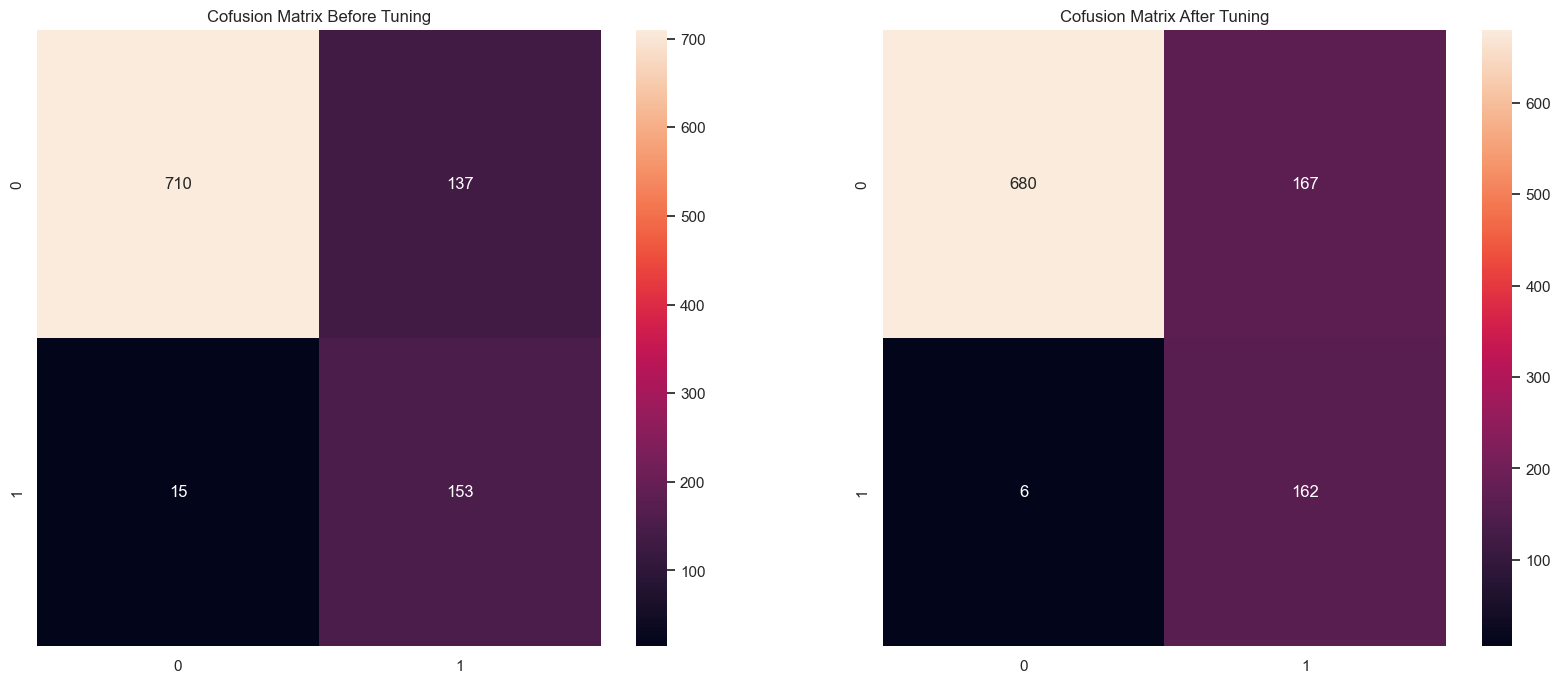

In [54]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test,y_pred_before_knn),annot=True,fmt='.0f')
plt.title('Cofusion Matrix Before Tuning')

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,y_pred_after_knn),annot=True,fmt='.0f')
plt.title('Cofusion Matrix After Tuning')

In [55]:
random_search_knn2.best_params_

{'transformer__pipe_median_scaling__scaling': MinMaxScaler(),
 'transformer__pipe_median_scaling__poly__degree': 3,
 'sampling': SMOTE(),
 'model__weights': 'distance',
 'model__p': 2,
 'model__n_neighbors': 13,
 'model__leaf_size': 10,
 'model__algorithm': 'kd_tree'}

Summary:
- The best Algorithm to use is KNeighbors 2nd tuning
    - KNeighbors before hyperparameter tuning Recall score: 0.9107142857142857
    - KNeighbors After Hyperparameter tuning Recall score:  0.9642857142857143
    - KNeighbors After Second Hyperparameter tuning Recall score:  0.9880952380952381
    - XGBoost before hyperparameter tuning Recall score: 0.9345238095238095
    - XGBoost after hyperparameter tuning Recall score: 0.9345238095238095

Because the KNeighbors Recall score after 2nd hyperparameter tuning is the best, so we will use the parameter of KNeigbors after 2nd tuning with parameter:

- transformer__pipe_median_scaling__scaling: MinMaxScaler()
- transformer__pipe_median_scaling__poly__degree: 3
- sampling: SMOTE()
- model__weights: distance
- model__p: 2
- model__n_neighbors: 13
- model__leaf_size: 10
- model__algorithm: kd_tree

How KNN Works:
- K-Nearest Neighbors (KNN) is a simple algorithm that uses the nearest training data points to make predictions for new data points. It's like asking your neighbors for advice, but instead of people, it's based on data. For classification, it picks the majority class among the nearest neighbors, while for regression it takes the average of their values. KNN is easy to use, but can be slow for large datasets, and the number of neighbors to consider is an important setting to tune.

## Comparison Scenario before and after Machine Learning

This is the porpotion of people that churn

In [56]:
y.value_counts()[1]/y.value_counts().sum()

0.165746945210879

In [57]:
true_negative = confusion_matrix(y_test,y_pred_after_knn)[0][0]
false_positive = confusion_matrix(y_test,y_pred_after_knn)[0][1]
false_negative = confusion_matrix(y_test,y_pred_after_knn)[1][0]
true_positive = confusion_matrix(y_test,y_pred_after_knn)[1][1]

this code is to see the percentage of churn before using machine learning

In [58]:
(true_positive+false_negative) / (true_positive+false_negative+true_negative+false_positive)

0.16551724137931034

this code is to see the percentage of churn after using machine Learning

In [59]:
false_negative / (true_positive+false_negative+true_negative+false_positive)

0.005911330049261084

By utilizing customer value of $40, we can calculate the financial loss experienced prior to the implementation of our machine learning model.

In [60]:
40*(6+161)

6680

By utilizing customer value of $40, we can calculate the financial loss experienced after to the implementation of our machine learning model.

In [61]:
40*6

240

The Total of Potential Income

In [62]:
40*(true_positive+true_negative+false_negative+false_positive)

40600

## Feature Importance

Since KNN has no Feature Importance in the model, we are going to use SHAP value to determine which variables are important

In [1]:
# pip install shap 

     -------------------------------------- 435.6/435.6 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [41]:
import shap

In [42]:
X_train_a = X_train[['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount','PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus']]

Using optimal parameter to run feature importance. Input is given directly

In [43]:
# Creating Pipeling for Collummns that we will fill the misssing value with median and then we scale, the numerical category that has no missing value we still input here because it will just pass it but it will go through the scaling too
pipe_median_poly_scaling = Pipeline([
    ('median', SimpleImputer(strategy='median')),
    ('poly',PolynomialFeatures(degree=3)),
    ('scaling',MinMaxScaler())
])


# Creating ColumnTransformer for the pipeline. Using column indices instead of column name
transformer = ColumnTransformer([
    ('pipe_median_scaling',pipe_median_poly_scaling, [0,1,2,3,4,5,6,7,8,9,10,11,12]),
    ('onehot', OneHotEncoder(drop='first'),[13,14,15,16,17])
],remainder='passthrough')

In [44]:
knn_model = Pipeline([    
    ('transformer', transformer),    
    ('sampling', SMOTE()),    
    ('model', KNeighborsClassifier(weights='distance',p=2,n_neighbors=13,leaf_size=10,algorithm='kd_tree'))])

In [45]:
knn_model.fit(X_train_a,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_median_scaling',
                                                  Pipeline(steps=[('median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12]),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                  

In [46]:
feature_names = X.columns

# define explainer
explainer = shap.KernelExplainer(
    knn_model.predict_proba,
    X_train_a.iloc[0:10],
    feature_dependence="independent",
    model_output="probability"    
)



Calculating shap value

In [47]:
# calculate shap value for 5 rows
shap_values = explainer.shap_values(shap.sample(X_train_a,10))

  0%|          | 0/10 [00:00<?, ?it/s]

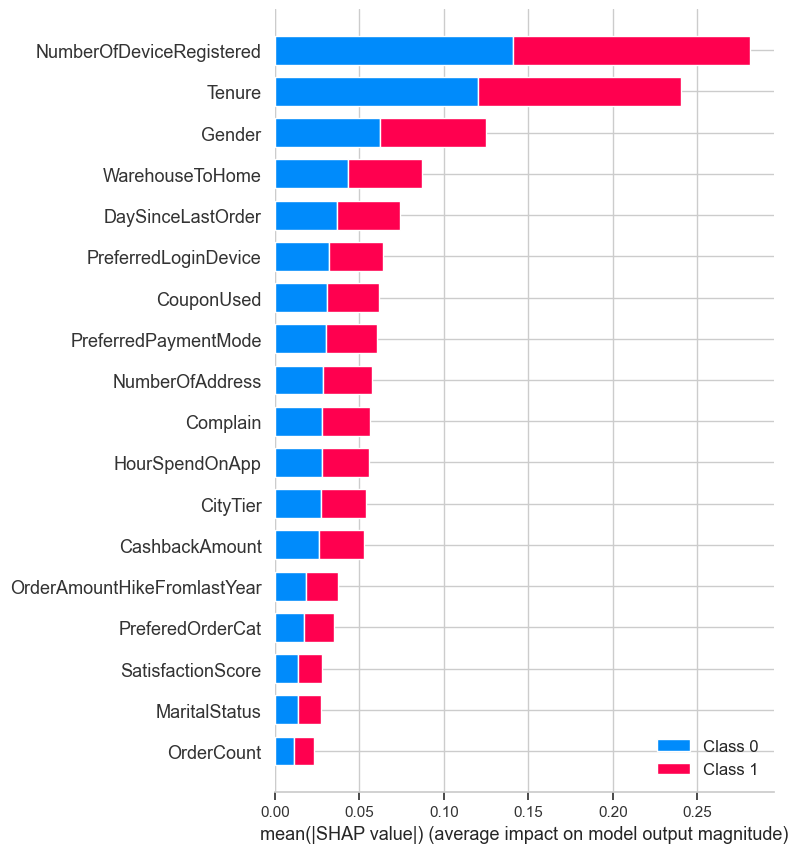

In [48]:
shap.summary_plot(shap_values, X_train_a, feature_names = feature_names)

**Interpretation:**

- Higher shap value means greater impact on determining outcome
- Number of device registered, tenure, gender, are top 3 variables that has the highest impact on the model

# Scenario How The Machine Learning Help Our Business

Prior to utilizing the machine learning model, our company experienced a lost of customer value, amounting to 16.5% of the total customer value, equating to $6,680 from    $40,600 potential customer value in USD. However, with the implementation of the machine learning model, we were able to significantly reduce this loss to just 0.5% of the total potential earnings, resulting in a decrease to $240 in USD for our loss.

In [63]:
X.describe()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,4833.000000,5063.000000,4842.000000,4833.000000,5063.000000,5063.000000,5063.000000,5063.000000,4812.000000,4854.000000,4820.000000,4775.000000,5063.000000
mean,10.170081,1.658305,15.500207,2.928823,3.687340,3.029627,4.182105,0.282441,15.708437,1.806551,3.096680,4.584921,177.634126
std,8.491233,0.919183,8.301269,0.723814,1.029595,1.384536,2.539459,0.450231,3.677216,1.948722,2.997784,3.662366,49.371320
min,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.910000
50%,9.000000,1.000000,13.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.880000
75%,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,198.045000
max,31.000000,3.000000,36.000000,5.000000,6.000000,5.000000,11.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


## Model Limitation

- Our data only have 18 features:
    - because of the limitation of our limited features so our data can be under-trained so the Machine Learning is not optimized

- Range Data:
    - This model can only predict accurately:
        - Tenure: 0 - 31
        - CityTier: 1 - 3
        - Warehousetohome: 5-36
        - Hours spend on app: 0 - 5
        - Numberofdevice: 1 - 6
        - Satisfation Score: 1 - 5
        - Number of address: 1 - 11
        - Complain: 0-1
        - OrderAmountHikeFromLastYear: 11 - 26
        - CouponUsed: 0 - 16
        - Order count: 1 - 16
        - Day since last order: 0-46
        - Cashback: 0 - 324

- Outliers:
    - There's still outliers in our data

# Model Performance Recommendation:
Things we can do to increase our model performance:

- Monitor performance regularly: Regular monitoring of the model's performance can help identify areas for improvement and make adjustments accordingly.

- Consider adding more data: The model's performance can be improved by incorporating more relevant data

- Test and validate the model: Regular testing and validation of the model can help ensure that it is working accurately and effectively.

- Collaborate with experts: Collaborating with machine learning experts and utilizing their expertise can help in further optimizing the model's performance.

- Adding More Data from customer experience

# Business Recommendation:

- Based on the machine learning model's high recall score of 98.8% in predicting customer churn, it is recommended that the business implement proactive measures to retain customers who are at a high risk of churning.

One way to do this is by using targeted marketing campaigns that focus on incentivizing customers to stay loyal to the business. For instance, offering personalized discounts or rewards to customers who have shown signs of disengagement, such as reduced usage of the product or service, can be an effective strategy to retain them.

# Conclusion

Why should we use the machine learning model for predicting customer churn in our daily operations?

Increase customer retention: By accurately predicting customer churn, we can proactively address potential issues and implement targeted retention strategies to retain customers who might have otherwise cancelled.

Improved decision making: The insights and predictions generated by the model can inform and guide our business decisions related to customer engagement, marketing, and product development, reducing the risk of costly mistakes and increasing overall profitability.

Targeted marketing and promotions: The model can help us identify and target high-risk customers who are more likely to churn, enabling us to design customized marketing campaigns and promotions that can effectively retain these customers.

By leveraging the power of machine learning to predict customer churn, we can gain a competitive advantage, streamline operations, and increase profits.

It's important to note that while machine learning can be a powerful tool for increasing profits, we need to use it ethically and responsibly. We should be transparent with customers about how their data is being used and obtain their consent when necessary. Additionally, we need to ensure that our model is fair, unbiased, and does not discriminate against any particular group of customers. By following these ethical principles, we can not only increase profits, but also build trust and credibility with our customers, partners, and stakeholders.